# Analysis of low wind speed events

In [1]:
import geopy.distance
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sn
import numpy as np
import xarray as xr
import json
import cartopy
from datetime import datetime
#from adjustText import adjust_text
import pandas as pd
import matplotlib.dates as mdates

In [2]:
DSHIP = xr.open_dataset('ipns://latest.orcestra-campaign.org/products/METEOR/DShip.zarr',engine='zarr')
DSHIP

<xarray.Dataset> Size: 20MB
Dimensions:           (time: 58980)
Coordinates:
    lat               (time) float64 472kB ...
    lon               (time) float64 472kB ...
  * time              (time) datetime64[ns] 472kB 2024-08-14 ... 2024-09-23T2...
Data variables: (12/39)
    PM1               (time) float64 472kB ...
    PM10              (time) float64 472kB ...
    PM2p5             (time) float64 472kB ...
    lwr               (time) float64 472kB ...
    p_air             (time) float64 472kB ...
    rh_board          (time) float64 472kB ...
    ...                ...
    wdir              (time) float64 472kB ...
    wdir_rel          (time) float64 472kB ...
    wspd              (time) float64 472kB ...
    wspd_kn           (time) float64 472kB ...
    wspd_rel          (time) float64 472kB ...
    wspd_rel_kn       (time) float64 472kB ...
Attributes:
    creator_email:  hans.segura@mpimet.mpg.de
    creator_name:   Hans Segura
    featureType:    trajectory
    history:        Converted to Zarr by Lukas Kluft (lukas.kluft@mpimet.mpg.de)
    license:        CC-BY-4.0
    platform:       RV METEOR
    project:        ORCESTRA, BOW-TIE
    source:         DVS DShip
    title:          Ship information database (DVS DShip) of METEOR cruise M203

In [3]:
# Find the index where shipTrackTime is 07:00 UTC on August 16
target_time = np.datetime64('2024-08-16T07:00:00')
index_start = np.where(DSHIP.time == target_time)[0]
index_start = int(index_start[0])

In [4]:
# Smooth wind speed with a running mean
tmean = 10 #minutes
wspd_smoothed = DSHIP.wspd[index_start:len(DSHIP.time)].rolling(time=tmean,center=True).mean() #running mean

In [5]:
# Define low wind speed events based on 10-min running mean wind speed < 3 m/s
wspd_threshold = 3

# Find indices where wspd_smoothed < wspd_threshold
ilowwind = wspd_smoothed < wspd_threshold

In [6]:
# Identify continuous low wind speed events
lowwind_events = []
in_event = False
event_start = None

for i in range(len(ilowwind)):
    if ilowwind[i] and not in_event:
        # Event starts
        event_start = i
        in_event = True
    elif not ilowwind[i] and in_event:
        # Event ends
        event_end = i
        lowwind_events.append((event_start, event_end))
        in_event = False

# If the last event goes until the end
if in_event:
    lowwind_events.append((event_start, len(ilowwind)))

# Filter out events that are too short
#min_event_length = 30 # minutes
#lowwind_events = [(start, end) for start, end in lowwind_events if (end - start) >= min_event_length]

# Create a DataFrame to store the low wind speed events
lowwind_df = pd.DataFrame(lowwind_events, columns=['start', 'end'])

# Convert the start and end times to datetime
start_indices = lowwind_df['start'].to_numpy()
end_indices = lowwind_df['end'].to_numpy()
times = DSHIP.time[index_start:len(DSHIP.time)].to_numpy()

lowwind_df['start_time'] = pd.to_datetime(times[start_indices])
lowwind_df['end_time'] = pd.to_datetime(times[end_indices])

# Calculate the duration of each event
lowwind_df['duration'] = lowwind_df['end_time'] - lowwind_df['start_time']

# Calculate the average 1-min wind speed during each event from DSHIP.wspd
lowwind_df['avg_wind_speed'] = np.nan
for i, (start, end) in enumerate(lowwind_events):
    avg_wind_speed = DSHIP.wspd[index_start + start:index_start + end].mean()
    lowwind_df.at[i, 'avg_wind_speed'] = avg_wind_speed

In [7]:
lowwind_df

,start,end,start_time,end_time,duration,avg_wind_speed
0,648,657,2024-08-16 17:48:00,2024-08-16 17:57:00,0 days 00:09:00,2.063889
1,762,785,2024-08-16 19:42:00,2024-08-16 20:05:00,0 days 00:23:00,2.855072
2,803,828,2024-08-16 20:23:00,2024-08-16 20:48:00,0 days 00:25:00,2.423467
3,870,877,2024-08-16 21:30:00,2024-08-16 21:37:00,0 days 00:07:00,2.907143
4,889,987,2024-08-16 21:49:00,2024-08-16 23:27:00,0 days 01:38:00,2.476020
...,...,...,...,...,...,...
131,54013,54020,2024-09-22 19:13:00,2024-09-22 19:20:00,0 days 00:07:00,2.770519
132,54041,54056,2024-09-22 19:41:00,2024-09-22 19:56:00,0 days 00:15:00,2.726402
133,54068,54078,2024-09-22 20:08:00,2024-09-22 20:18:00,0 days 00:10:00,2.462906
134,54095,54111,2024-09-22 20:35:00,2024-09-22 20:51:00,0 days 00:16:00,2.908709


In [8]:
# Find maximum duration
max_duration = lowwind_df['duration'].max()
max_duration

Timedelta('0 days 15:15:00')

In [9]:
# Find events with duration > 6 hours
long_events = lowwind_df[lowwind_df['duration'] > pd.Timedelta(hours=6)]
long_events

,start,end,start_time,end_time,duration,avg_wind_speed
8,10881,11420,2024-08-23 20:21:00,2024-08-24 05:20:00,0 days 08:59:00,1.555306
15,14650,15565,2024-08-26 11:10:00,2024-08-27 02:25:00,0 days 15:15:00,1.560974


In [17]:
# Find minimum average wind speed
min_avg_wind_speed = lowwind_df['avg_wind_speed'].min()
min_avg_wind_speed

np.float64(1.3940860215053763)

Text(0.5, 1.0, 'Low Wind Speed Event (10-min running mean < 3 m s$^{-1}$) Durations')

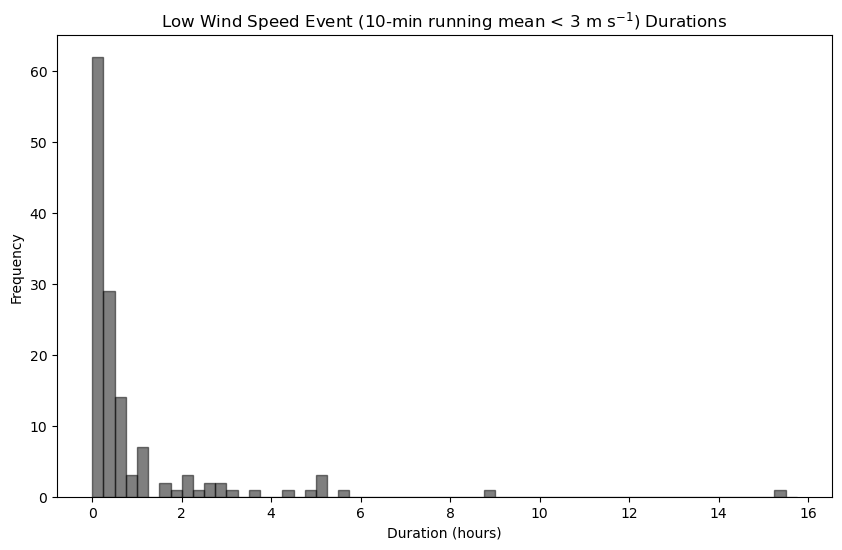

In [25]:
# Plot histogram of low wind speed event durations
plt.figure(figsize=(10, 6))

bins = np.arange(0, 16, 0.25)  # 0 to 24 hours in 15-minute bins
counts, bin_edges, patches = plt.hist(lowwind_df['duration'].dt.total_seconds() / 3600, bins=bins, color='black', alpha=0.5, edgecolor='black')

plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.title('Low Wind Speed Event (10-min running mean < 3 m s$^{-1}$) Durations')

Precipitation statistics during low wind speed events

In [9]:
# Read in SEA-POL average low-level rain rate data

#load data
rain = xr.open_dataset('../../data/SEA-POL_gridded_rainrate_spatial_means_masked.nc')
rain

<xarray.Dataset> Size: 213kB
Dimensions:       (time: 4447)
Coordinates:
  * time          (time) datetime64[ns] 36kB 2024-08-16T08:10:52.949000192 .....
Data variables:
    rain245_mean  (time) float32 18kB ...
    rain120_mean  (time) float32 18kB ...
    rain60_mean   (time) float32 18kB ...
    rain12_mean   (time) float32 18kB ...
    rain1_mean    (time) float32 18kB ...
    rain245_int   (time) float32 18kB ...
    rain120_int   (time) float32 18kB ...
    rain60_int    (time) float32 18kB ...
    rain12_int    (time) float32 18kB ...
    rain1_int     (time) float32 18kB ...
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4a Gridded Rain Rate
    units:        mm/h

In [47]:
# Extract precip at times of low-wind speed events

for idx, row in lowwind_df.iterrows():
    # Get the time range for the event
    time_range = pd.date_range(lowwind_df['start_time'][idx], lowwind_df['end_time'][idx], freq='1min')
    
    # Select the rain data in the the time range, take mean over event
    rain_lowwind_event = rain.sel(time=time_range,method='nearest').mean(dim='time',skipna=True)

    # Store the interpolated rain data in the DataFrame
    lowwind_df.at[idx, 'Precip - 1 km'] = rain_lowwind_event.rain1_mean.values
    lowwind_df.at[idx, 'Precip - 12 km'] = rain_lowwind_event.rain12_mean.values
    lowwind_df.at[idx, 'Precip - 60 km'] = rain_lowwind_event.rain60_mean.values
    lowwind_df.at[idx, 'Precip - 120 km'] = rain_lowwind_event.rain120_mean.values
    lowwind_df.at[idx, 'Precip - 245 km'] = rain_lowwind_event.rain245_mean.values

In [27]:
lowwind_df

,start,end,start_time,end_time,duration,avg_wind_speed,Precip - 1 km,Precip - 12 km,Precip - 60 km,Precip - 120 km,Precip - 245 km
0,648,657,2024-08-16 17:48:00,2024-08-16 17:57:00,0 days 00:09:00,2.063889,NaN,NaN,NaN,NaN,NaN
1,762,785,2024-08-16 19:42:00,2024-08-16 20:05:00,0 days 00:23:00,2.855072,NaN,NaN,NaN,NaN,NaN
2,803,828,2024-08-16 20:23:00,2024-08-16 20:48:00,0 days 00:25:00,2.423467,NaN,NaN,NaN,NaN,NaN
3,870,877,2024-08-16 21:30:00,2024-08-16 21:37:00,0 days 00:07:00,2.907143,NaN,NaN,NaN,NaN,NaN
4,889,987,2024-08-16 21:49:00,2024-08-16 23:27:00,0 days 01:38:00,2.476020,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
131,54013,54020,2024-09-22 19:13:00,2024-09-22 19:20:00,0 days 00:07:00,2.770519,0.000000,0.002170,0.015188,0.003856,0.001143
132,54041,54056,2024-09-22 19:41:00,2024-09-22 19:56:00,0 days 00:15:00,2.726402,0.000000,0.005692,0.012936,0.012578,0.003739
133,54068,54078,2024-09-22 20:08:00,2024-09-22 20:18:00,0 days 00:10:00,2.462906,0.000000,0.960219,0.145231,0.075905,0.023786
134,54095,54111,2024-09-22 20:35:00,2024-09-22 20:51:00,0 days 00:16:00,2.908709,0.000000,0.892505,0.139059,0.071227,0.022338


In [49]:
#Extract only low wind events with a minimum duration
lowwind_df_30m = lowwind_df[lowwind_df['duration'] > pd.Timedelta(minutes=30)]
lowwind_df_1h = lowwind_df[lowwind_df['duration'] > pd.Timedelta(hours=1)]
lowwind_df_3h = lowwind_df[lowwind_df['duration'] > pd.Timedelta(hours=3)]
lowwind_df_6h = lowwind_df[lowwind_df['duration'] > pd.Timedelta(hours=6)]

In [45]:
# Extract all precip indices for low wind events of various durations
data_df = lowwind_df
time_indices_all = np.full((len(data_df),16*6), np.nan)
iidx=0
for idx, row in data_df.iterrows():
    # Find the indices of rain.time in that time range
    time_indices = np.where((rain.time >= data_df['start_time'][idx]) & (rain.time <= data_df['end_time'][idx]))[0]
    time_indices_all[iidx, 0:len(time_indices)] = time_indices
    iidx = iidx+1
# Reshape into long array
time_indices_all = time_indices_all.reshape(-1)
# Remove NaN values
time_indices_all = time_indices_all[~np.isnan(time_indices_all)]
# Convert to integer
time_indices_all = time_indices_all.astype(int)


#### 30 Min############################
data_df = lowwind_df_30m
time_indices_30m = np.full((len(data_df),16*6), np.nan)
iidx=0
for idx, row in data_df.iterrows():
    # Find the indices of rain.time in that time range
    time_indices = np.where((rain.time >= data_df['start_time'][idx]) & (rain.time <= data_df['end_time'][idx]))[0]
    time_indices_30m[iidx, 0:len(time_indices)] = time_indices
    iidx = iidx+1
# Reshape into long array
time_indices_30m = time_indices_30m.reshape(-1)
# Remove NaN values
time_indices_30m = time_indices_30m[~np.isnan(time_indices_30m)]
# Convert to integer
time_indices_30m = time_indices_30m.astype(int)

################1 hour #####################
data_df = lowwind_df_1h
time_indices_1h = np.full((len(data_df),16*6), np.nan)
iidx=0
for idx, row in data_df.iterrows():
    # Find the indices of rain.time in that time range
    time_indices = np.where((rain.time >= data_df['start_time'][idx]) & (rain.time <= data_df['end_time'][idx]))[0]
    time_indices_1h[iidx, 0:len(time_indices)] = time_indices
    iidx = iidx+1
# Reshape into long array
time_indices_1h = time_indices_1h.reshape(-1)
# Remove NaN values
time_indices_1h = time_indices_1h[~np.isnan(time_indices_1h)]
# Convert to integer
time_indices_1h = time_indices_1h.astype(int)

#################### 3 hours #####################
data_df = lowwind_df_3h
time_indices_3h = np.full((len(data_df),16*6), np.nan)
iidx=0
for idx, row in data_df.iterrows():
    # Find the indices of rain.time in that time range
    time_indices = np.where((rain.time >= data_df['start_time'][idx]) & (rain.time <= data_df['end_time'][idx]))[0]
    time_indices_3h[iidx, 0:len(time_indices)] = time_indices
    iidx = iidx+1
# Reshape into long array
time_indices_3h = time_indices_3h.reshape(-1)
# Remove NaN values
time_indices_3h = time_indices_3h[~np.isnan(time_indices_3h)]
# Convert to integer
time_indices_3h = time_indices_3h.astype(int)

#################### 6 hours #####################
data_df = lowwind_df_6h
time_indices_6h = np.full((len(data_df),16*6), np.nan)
iidx=0
for idx, row in data_df.iterrows():
    # Find the indices of rain.time in that time range
    time_indices = np.where((rain.time >= data_df['start_time'][idx]) & (rain.time <= data_df['end_time'][idx]))[0]
    time_indices_6h[iidx, 0:len(time_indices)] = time_indices
    iidx = iidx+1
# Reshape into long array
time_indices_6h = time_indices_6h.reshape(-1)
# Remove NaN values
time_indices_6h = time_indices_6h[~np.isnan(time_indices_6h)]
# Convert to integer
time_indices_6h = time_indices_6h.astype(int)



Text(0.5, 1.0, 'Precipitation during low wind speed events')

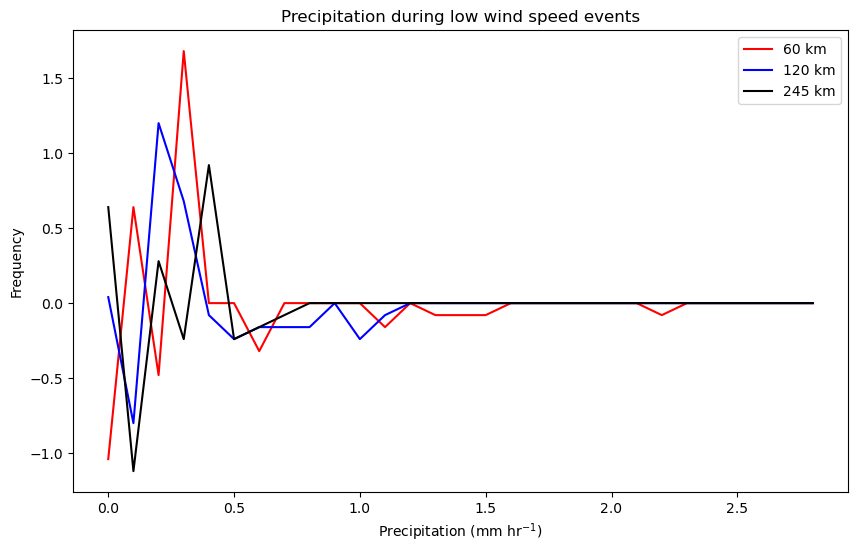

In [75]:
# Plot histogram of precip during low wind speed events
plt.figure(figsize=(10, 6))

bins = np.arange(0, 3, 0.1)
#bins = np.concatenate(([0],np.power(10,np.arange(-4,1,0.1))))

phist1, bin_edges1 = np.histogram(lowwind_df['Precip - 1 km'], bins=bins, density=True)
phist2, bin_edges2 = np.histogram(lowwind_df['Precip - 12 km'], bins=bins, density=True)
phist3, bin_edges3 = np.histogram(lowwind_df['Precip - 60 km'], bins=bins, density=True)
phist4, bin_edges4 = np.histogram(lowwind_df['Precip - 120 km'], bins=bins, density=True)
phist5, bin_edges5 = np.histogram(lowwind_df['Precip - 245 km'], bins=bins, density=True)

phist1a, bin_edges1a = np.histogram(lowwind_df_3h['Precip - 1 km'], bins=bins, density=True)
phist2a, bin_edges2a = np.histogram(lowwind_df_3h['Precip - 12 km'], bins=bins, density=True)
phist3a, bin_edges3a = np.histogram(lowwind_df_3h['Precip - 60 km'], bins=bins, density=True)
phist4a, bin_edges4a = np.histogram(lowwind_df_3h['Precip - 120 km'], bins=bins, density=True)
phist5a, bin_edges5a = np.histogram(lowwind_df_3h['Precip - 245 km'], bins=bins, density=True)

#plt.plot(bin_edges1[:-1], phist1a-phist1, color='green', label='1 km')
#plt.plot(bin_edges2[:-1], phist2a-phist2, color='purple', label='12 km')
plt.plot(bin_edges3[:-1], phist3a-phist3, color='red', label='60 km')
plt.plot(bin_edges4[:-1], phist4a-phist4, color='blue', label='120 km')
plt.plot(bin_edges5[:-1], phist5a-phist5, color='black', label='245 km')

plt.legend()
plt.xlabel('Precipitation (mm hr$^{-1}$)')
plt.ylabel('Frequency')
plt.title('Precipitation during low wind speed events')

/tmp/ipykernel_3682474/985920220.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[4].set_xticklabels(axs[4].get_xticklabels(), fontsize=18)


[Text(19957.0, 0, '22'),
 Text(19967.0, 0, 'Sep'),
 Text(19974.0, 0, '08'),
 Text(19981.0, 0, '15'),
 Text(19988.0, 0, '22')]

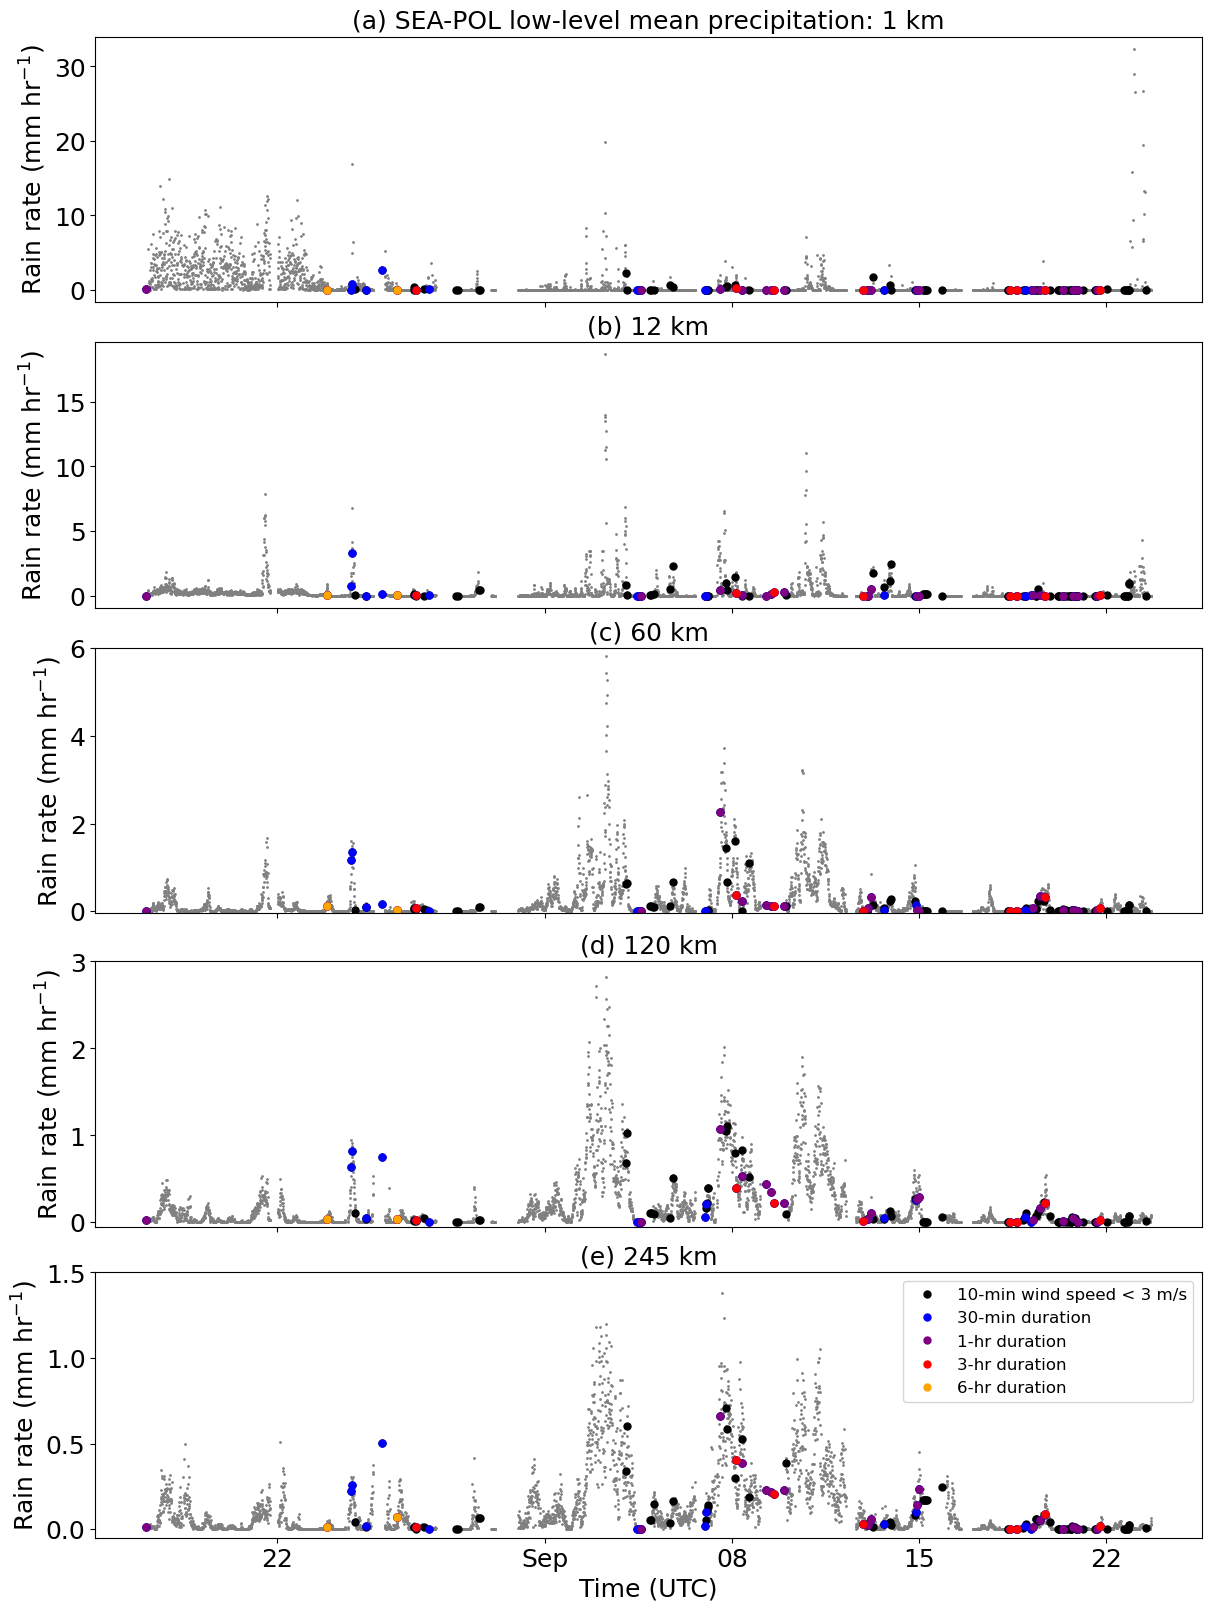

In [53]:
# Plot time series of precip & during low wind speed events
fig,axs = plt.subplots(5,1,figsize=(12,16),layout="constrained")

#plt.plot(DSHIP.time[index_start:len(DSHIP.time)][ilowwind], wspd_smoothed[ilowwind], 'o', markersize=1, color='gray')

############# 1 km
axs[0].plot(rain.time, rain.rain1_mean, '.', markersize = 2, color='gray')
axs[0].plot(lowwind_df['start_time'],lowwind_df['Precip - 1 km'],'.',markersize=10, color='black')
axs[0].plot(lowwind_df_30m['start_time'],lowwind_df_30m['Precip - 1 km'],'.',markersize=10, color='blue')
axs[0].plot(lowwind_df_1h['start_time'],lowwind_df_1h['Precip - 1 km'],'.',markersize=10, color='purple')
axs[0].plot(lowwind_df_3h['start_time'],lowwind_df_3h['Precip - 1 km'],'.',markersize=10, color='red')
axs[0].plot(lowwind_df_6h['start_time'],lowwind_df_6h['Precip - 1 km'],'.',markersize=10, color='orange')

axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

#axs[0].set_xlabel('Time (UTC)', fontsize=18)
axs[0].set_ylabel('Rain rate (mm hr$^{-1}$)', fontsize=18)
axs[0].set_title('(a) SEA-POL low-level mean precipitation: 1 km', fontsize=18)

axs[0].set_xticklabels('')
axs[0].tick_params(axis='y', labelsize=18)

################## 12 km
axs[1].plot(rain.time, rain.rain12_mean, '.', markersize = 2, color='gray')
axs[1].plot(lowwind_df['start_time'],lowwind_df['Precip - 12 km'],'.',markersize=10, color='black')
axs[1].plot(lowwind_df_30m['start_time'],lowwind_df_30m['Precip - 12 km'],'.',markersize=10, color='blue')
axs[1].plot(lowwind_df_1h['start_time'],lowwind_df_1h['Precip - 12 km'],'.',markersize=10, color='purple')
axs[1].plot(lowwind_df_3h['start_time'],lowwind_df_3h['Precip - 12 km'],'.',markersize=10, color='red')
axs[1].plot(lowwind_df_6h['start_time'],lowwind_df_6h['Precip - 12 km'],'.',markersize=10, color='orange')

axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[1].xaxis.get_major_locator()))

#axs[1].set_xlabel('Time (UTC)', fontsize=18)
axs[1].set_ylabel('Rain rate (mm hr$^{-1}$)', fontsize=18)
axs[1].set_title('(b) 12 km', fontsize=18)

axs[1].set_xticklabels('')
axs[1].tick_params(axis='y', labelsize=18)

################## 60 km
axs[2].plot(rain.time, rain.rain60_mean, '.', markersize = 2, color='gray')
axs[2].plot(lowwind_df['start_time'],lowwind_df['Precip - 60 km'],'.',markersize=10, color='black')
axs[2].plot(lowwind_df_30m['start_time'],lowwind_df_30m['Precip - 60 km'],'.',markersize=10, color='blue')
axs[2].plot(lowwind_df_1h['start_time'],lowwind_df_1h['Precip - 60 km'],'.',markersize=10, color='purple')
axs[2].plot(lowwind_df_3h['start_time'],lowwind_df_3h['Precip - 60 km'],'.',markersize=10, color='red')
axs[2].plot(lowwind_df_6h['start_time'],lowwind_df_6h['Precip - 60 km'],'.',markersize=10, color='orange')

axs[2].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[2].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[2].xaxis.get_major_locator()))

#axs[2].set_xlabel('Time (UTC)', fontsize=18)
axs[2].set_ylabel('Rain rate (mm hr$^{-1}$)', fontsize=18)
axs[2].set_title('(c) 60 km', fontsize=18)

axs[2].set_ylim(-0.05, 6)

axs[2].set_xticklabels('')
axs[2].tick_params(axis='y', labelsize=18)

################## 120 km
axs[3].plot(rain.time, rain.rain120_mean, '.', markersize = 2, color='gray')
axs[3].plot(lowwind_df['start_time'],lowwind_df['Precip - 120 km'],'.',markersize = 10, color='black')
axs[3].plot(lowwind_df_30m['start_time'],lowwind_df_30m['Precip - 120 km'],'.',markersize = 10, color='blue')
axs[3].plot(lowwind_df_1h['start_time'],lowwind_df_1h['Precip - 120 km'],'.',markersize=10, color='purple')
axs[3].plot(lowwind_df_3h['start_time'],lowwind_df_3h['Precip - 120 km'],'.',markersize=10, color='red')
axs[3].plot(lowwind_df_6h['start_time'],lowwind_df_6h['Precip - 120 km'],'.',markersize=10, color='orange')

axs[3].set_ylim(-0.05, 3)

axs[3].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[3].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[3].xaxis.get_major_locator()))

#axs[3].set_xlabel('Time (UTC)', fontsize=18)
axs[3].set_ylabel('Rain rate (mm hr$^{-1}$)', fontsize=18)
axs[3].set_title('(d) 120 km', fontsize=18)

axs[3].set_xticklabels('')
axs[3].tick_params(axis='y', labelsize=18)

################## 245 km
axs[4].plot(rain.time, rain.rain245_mean, '.', markersize = 2, color='gray')
axs[4].plot(lowwind_df['start_time'],lowwind_df['Precip - 245 km'],'.', markersize = 10, color='black',label='10-min wind speed < 3 m/s')
axs[4].plot(lowwind_df_30m['start_time'],lowwind_df_30m['Precip - 245 km'],'.',markersize = 10, color='blue', label='30-min duration')
axs[4].plot(lowwind_df_1h['start_time'],lowwind_df_1h['Precip - 245 km'],'.',markersize = 10, color='purple', label='1-hr duration')
axs[4].plot(lowwind_df_3h['start_time'],lowwind_df_3h['Precip - 245 km'],'.',markersize = 10, color='red', label='3-hr duration')
axs[4].plot(lowwind_df_6h['start_time'],lowwind_df_6h['Precip - 245 km'],'.',markersize = 10, color='orange', label='6-hr duration')
axs[4].legend(loc='upper right', fontsize=12)

axs[4].set_ylim(-0.05, 1.5)

axs[4].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[4].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[4].xaxis.get_major_locator()))

axs[4].set_xlabel('Time (UTC)', fontsize=18)
axs[4].set_ylabel('Rain rate (mm hr$^{-1}$)', fontsize=18)
axs[4].set_title('(e) 245 km', fontsize=18)

axs[4].tick_params(axis='y', labelsize=18)
axs[4].set_xticklabels(axs[4].get_xticklabels(), fontsize=18)

/tmp/ipykernel_3782042/1196724320.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[4].set_xticklabels(axs[4].get_xticklabels(), fontsize=18)


[Text(19957.0, 0, '22'),
 Text(19967.0, 0, 'Sep'),
 Text(19974.0, 0, '08'),
 Text(19981.0, 0, '15'),
 Text(19988.0, 0, '22')]

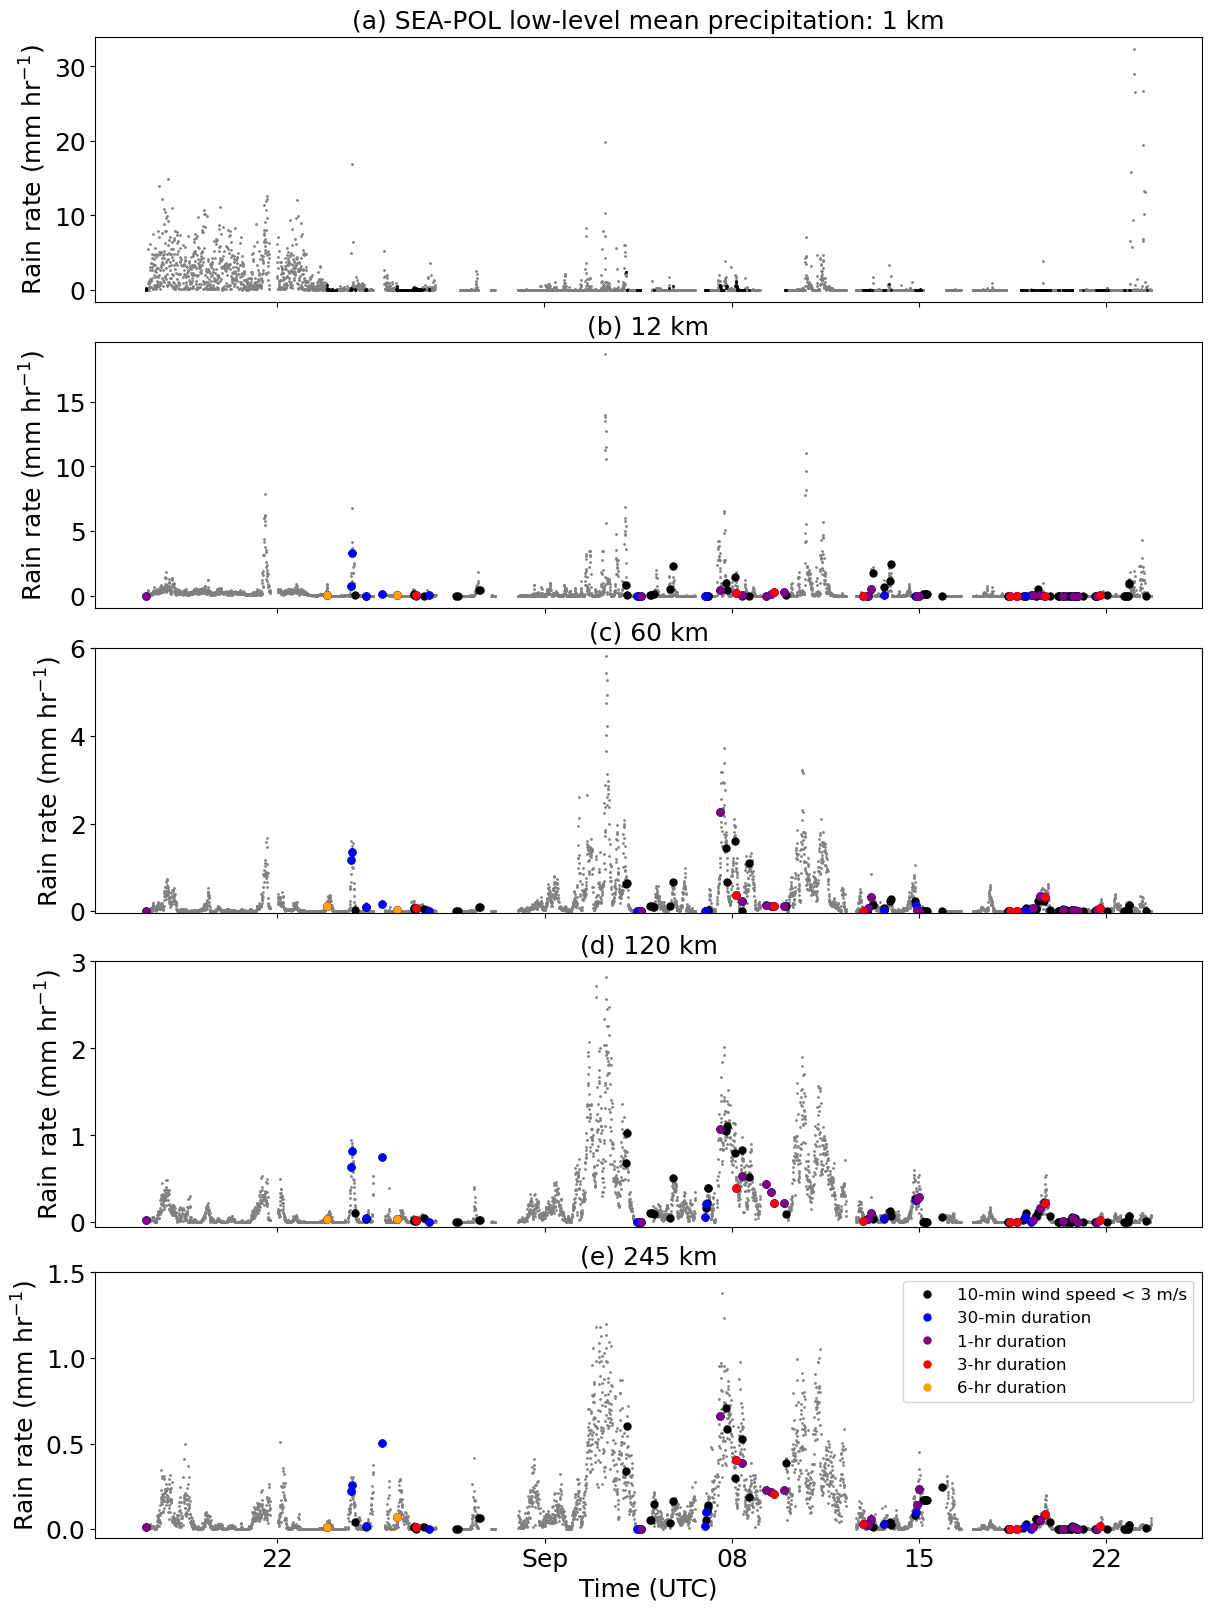

In [50]:
# Plot time series of precip & during low wind speed events
fig,axs = plt.subplots(5,1,figsize=(12,16),layout="constrained")

#plt.plot(DSHIP.time[index_start:len(DSHIP.time)][ilowwind], wspd_smoothed[ilowwind], 'o', markersize=1, color='gray')

############# 1 km
axs[0].plot(rain.time, rain.rain1_mean, '.', markersize = 2, color='gray')
axs[0].plot(rain.time[time_indices_all], rain.rain1_mean[time_indices_all], '.', markersize=2, color='black')


axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

#axs[0].set_xlabel('Time (UTC)', fontsize=18)
axs[0].set_ylabel('Rain rate (mm hr$^{-1}$)', fontsize=18)
axs[0].set_title('(a) SEA-POL low-level mean precipitation: 1 km', fontsize=18)

axs[0].set_xticklabels('')
axs[0].tick_params(axis='y', labelsize=18)

################## 12 km
axs[1].plot(rain.time, rain.rain12_mean, '.', markersize = 2, color='gray')
axs[1].plot(lowwind_df['start_time'],lowwind_df['Precip - 12 km'],'.',markersize=10, color='black')
axs[1].plot(lowwind_df_30m['start_time'],lowwind_df_30m['Precip - 12 km'],'.',markersize=10, color='blue')
axs[1].plot(lowwind_df_1h['start_time'],lowwind_df_1h['Precip - 12 km'],'.',markersize=10, color='purple')
axs[1].plot(lowwind_df_3h['start_time'],lowwind_df_3h['Precip - 12 km'],'.',markersize=10, color='red')
axs[1].plot(lowwind_df_6h['start_time'],lowwind_df_6h['Precip - 12 km'],'.',markersize=10, color='orange')

axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[1].xaxis.get_major_locator()))

#axs[1].set_xlabel('Time (UTC)', fontsize=18)
axs[1].set_ylabel('Rain rate (mm hr$^{-1}$)', fontsize=18)
axs[1].set_title('(b) 12 km', fontsize=18)

axs[1].set_xticklabels('')
axs[1].tick_params(axis='y', labelsize=18)

################## 60 km
axs[2].plot(rain.time, rain.rain60_mean, '.', markersize = 2, color='gray')
axs[2].plot(lowwind_df['start_time'],lowwind_df['Precip - 60 km'],'.',markersize=10, color='black')
axs[2].plot(lowwind_df_30m['start_time'],lowwind_df_30m['Precip - 60 km'],'.',markersize=10, color='blue')
axs[2].plot(lowwind_df_1h['start_time'],lowwind_df_1h['Precip - 60 km'],'.',markersize=10, color='purple')
axs[2].plot(lowwind_df_3h['start_time'],lowwind_df_3h['Precip - 60 km'],'.',markersize=10, color='red')
axs[2].plot(lowwind_df_6h['start_time'],lowwind_df_6h['Precip - 60 km'],'.',markersize=10, color='orange')

axs[2].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[2].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[2].xaxis.get_major_locator()))

#axs[2].set_xlabel('Time (UTC)', fontsize=18)
axs[2].set_ylabel('Rain rate (mm hr$^{-1}$)', fontsize=18)
axs[2].set_title('(c) 60 km', fontsize=18)

axs[2].set_ylim(-0.05, 6)

axs[2].set_xticklabels('')
axs[2].tick_params(axis='y', labelsize=18)

################## 120 km
axs[3].plot(rain.time, rain.rain120_mean, '.', markersize = 2, color='gray')
axs[3].plot(lowwind_df['start_time'],lowwind_df['Precip - 120 km'],'.',markersize = 10, color='black')
axs[3].plot(lowwind_df_30m['start_time'],lowwind_df_30m['Precip - 120 km'],'.',markersize = 10, color='blue')
axs[3].plot(lowwind_df_1h['start_time'],lowwind_df_1h['Precip - 120 km'],'.',markersize=10, color='purple')
axs[3].plot(lowwind_df_3h['start_time'],lowwind_df_3h['Precip - 120 km'],'.',markersize=10, color='red')
axs[3].plot(lowwind_df_6h['start_time'],lowwind_df_6h['Precip - 120 km'],'.',markersize=10, color='orange')

axs[3].set_ylim(-0.05, 3)

axs[3].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[3].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[3].xaxis.get_major_locator()))

#axs[3].set_xlabel('Time (UTC)', fontsize=18)
axs[3].set_ylabel('Rain rate (mm hr$^{-1}$)', fontsize=18)
axs[3].set_title('(d) 120 km', fontsize=18)

axs[3].set_xticklabels('')
axs[3].tick_params(axis='y', labelsize=18)

################## 245 km
axs[4].plot(rain.time, rain.rain245_mean, '.', markersize = 2, color='gray')
axs[4].plot(lowwind_df['start_time'],lowwind_df['Precip - 245 km'],'.', markersize = 10, color='black',label='10-min wind speed < 3 m/s')
axs[4].plot(lowwind_df_30m['start_time'],lowwind_df_30m['Precip - 245 km'],'.',markersize = 10, color='blue', label='30-min duration')
axs[4].plot(lowwind_df_1h['start_time'],lowwind_df_1h['Precip - 245 km'],'.',markersize = 10, color='purple', label='1-hr duration')
axs[4].plot(lowwind_df_3h['start_time'],lowwind_df_3h['Precip - 245 km'],'.',markersize = 10, color='red', label='3-hr duration')
axs[4].plot(lowwind_df_6h['start_time'],lowwind_df_6h['Precip - 245 km'],'.',markersize = 10, color='orange', label='6-hr duration')
axs[4].legend(loc='upper right', fontsize=12)

axs[4].set_ylim(-0.05, 1.5)

axs[4].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[4].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[4].xaxis.get_major_locator()))

axs[4].set_xlabel('Time (UTC)', fontsize=18)
axs[4].set_ylabel('Rain rate (mm hr$^{-1}$)', fontsize=18)
axs[4].set_title('(e) 245 km', fontsize=18)

axs[4].tick_params(axis='y', labelsize=18)
axs[4].set_xticklabels(axs[4].get_xticklabels(), fontsize=18)